In [45]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text


import shap

In [2]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_31479/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [31]:
df = df0.copy()

#Make everything lower case, and replace space with '_'
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)
print('Types of variables in bp_category:',df['bp_category'].nunique())

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f'Classes for column {col}:',label_encoders[col].classes_)

# dv = DictVectorizer(sparse=False)
# dv.fit_transform(df[categorical_columns])
    
print(df.columns.tolist())

#omit_cols = ['blood_pressure', 'systolic', 'diastolic']
omit_cols = ['blood_pressure', 'systolic', 'diastolic', 'medical_issue', 'stress_level', 'ongoing_medication', 'age', 'smart_device_before_bed', 'blue-light_filter', 'daily_steps', 'sleep_quality', 'smoking']
df = df.drop(columns=omit_cols)

Types of variables in bp_category: 3
Classes for column gender: ['F' 'M']
Classes for column blood_pressure: ['100/60' '100/61' '100/62' ... '99/88' '99/89' '99/90']
Classes for column sleep_disorder: ['N' 'Y']
Classes for column wake_up_during_night: ['N' 'Y']
Classes for column feel_sleepy_during_day: ['N' 'Y']
Classes for column caffeine_consumption: ['N' 'Y']
Classes for column alcohol_consumption: ['N' 'Y']
Classes for column smoking: ['N' 'Y']
Classes for column medical_issue: ['N' 'Y']
Classes for column ongoing_medication: ['N' 'Y']
Classes for column smart_device_before_bed: ['N' 'Y']
Classes for column blue-light_filter: ['N' 'Y']
Classes for column discomfort_eye-strain: ['N' 'Y']
Classes for column redness_in_eye: ['N' 'Y']
Classes for column itchiness/irritation_in_eye: ['N' 'Y']
Classes for column dry_eye_disease: ['N' 'Y']
Classes for column systolic: ['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111'
 '112' '113' '114' '115' '116' '117' '118' '119'

In [32]:
#Select the target columns
target_cols = ['dry_eye_disease'] 
y = df[target_cols]

#Drop the target columns, so the rest are feature columns
X = df.drop(columns=target_cols)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [53]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    scores.append((n, auc))

/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/sit

In [48]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])


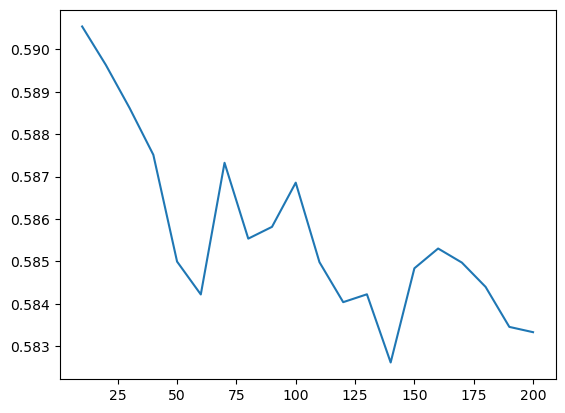

In [49]:
plt.plot(df_scores.n_estimators, df_scores.auc)


In [54]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)

        scores.append((d, n, auc))

/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/sit

In [55]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

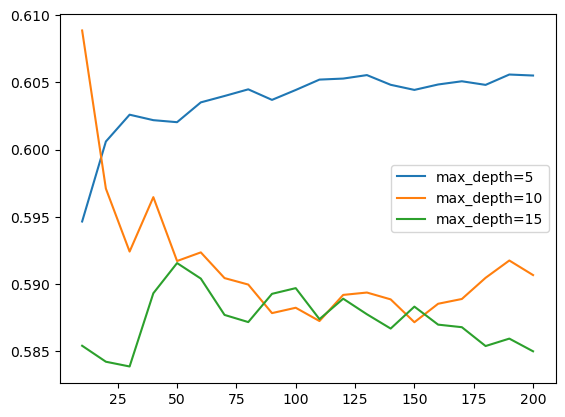

In [56]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [58]:
max_depth = 5

In [59]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)

        scores.append((s, n, auc))

/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/debanjansarkar/anaconda3/envs/erdos_spring_2025/lib/python3.12/sit

In [60]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

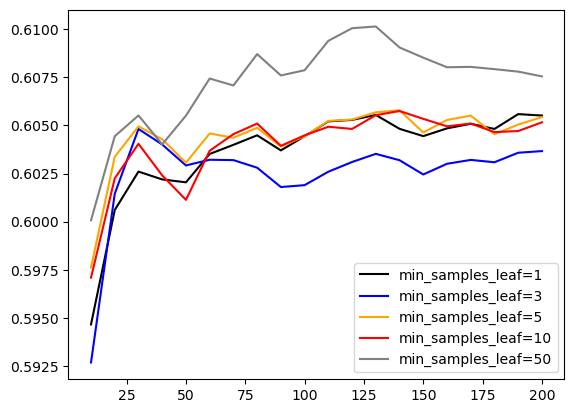

In [61]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()